In [51]:
import os
import numpy as np
import pandas as pd

data_path = os.path.join("eDo", 'data', '03.csv')
df = pd.read_csv(data_path, parse_dates=['DateTime'])
df.sort_values("DateTime", inplace=True)
df.columns

lookahead = 10

# Astrology features

...god i hate technical indicators

In [52]:
import pandas as pd
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands, AverageTrueRange

rsi_indicator = RSIIndicator(close=df['Close'], window=14)
for rsi_window in [7, 14, 28]:
    rsi_indicator = RSIIndicator(close=df['Close'], window=rsi_window)
    df[f'RSI_{rsi_window}'] = rsi_indicator.rsi()

macd_default = MACD(
    close=df['Close'],
    window_slow=26,
    window_fast=12,
    window_sign=9
)
df['MACD_26_12']       = macd_default.macd()
df['MACD_signal_26_12'] = macd_default.macd_signal()
df['MACD_diff_26_12']   = macd_default.macd_diff()

macd_short = MACD(
    close=df['Close'],
    window_slow=19,
    window_fast=8,
    window_sign=9
)
df['MACD_19_8']       = macd_short.macd()
df['MACD_signal_19_8'] = macd_short.macd_signal()
df['MACD_diff_19_8']   = macd_short.macd_diff()

for stoch_window in [7, 14, 21]:
    stoch_indicator = StochasticOscillator(
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        window=stoch_window,
        smooth_window=3
    )
    df[f'%K_{stoch_window}'] = stoch_indicator.stoch()
    df[f'%D_{stoch_window}'] = stoch_indicator.stoch_signal()


for atr_window in [7, 14, 28]:
    atr_indicator = AverageTrueRange(
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        window=atr_window
    )
    df[f'ATR_{atr_window}'] = atr_indicator.average_true_range()


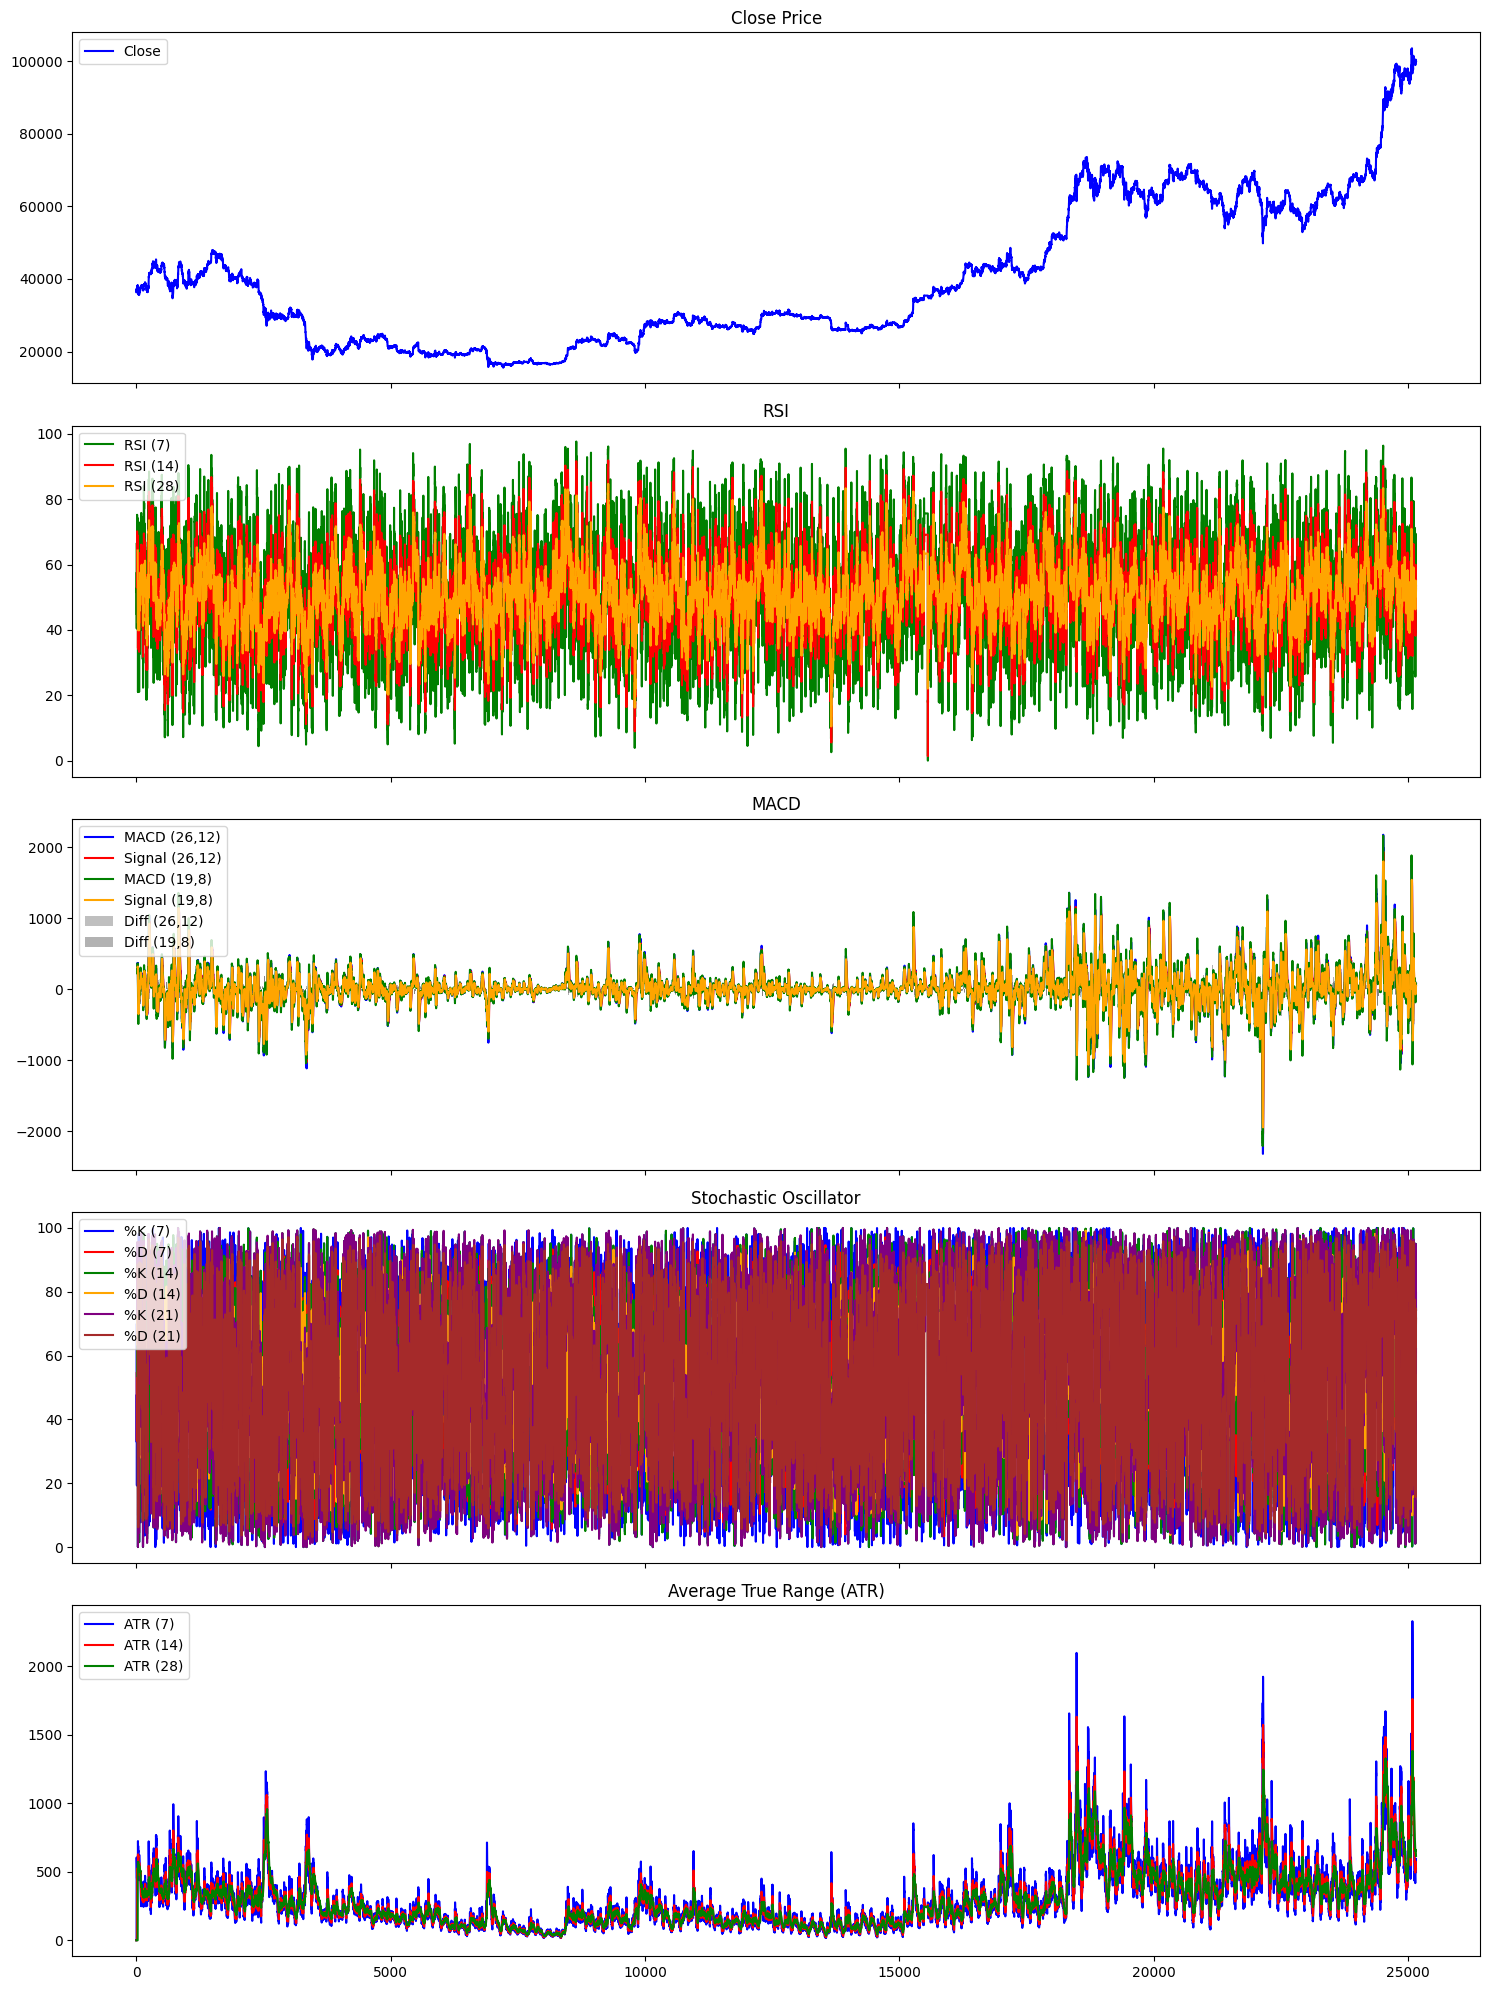

In [53]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

# Closing Price
axes[0].plot(df.index, df['Close'], label='Close', color='blue')
axes[0].set_title('Close Price')
axes[0].legend(loc='upper left')

# RSI
axes[1].plot(df.index, df['RSI_7'], label='RSI (7)', color='green')
axes[1].plot(df.index, df['RSI_14'], label='RSI (14)', color='red')
axes[1].plot(df.index, df['RSI_28'], label='RSI (28)', color='orange')
axes[1].set_title('RSI')
axes[1].legend(loc='upper left')

# MACD
axes[2].set_title('MACD')
# Default MACD
axes[2].plot(df.index, df['MACD_26_12'], label='MACD (26,12)', color='blue')
axes[2].plot(df.index, df['MACD_signal_26_12'], label='Signal (26,12)', color='red')
axes[2].bar(df.index, df['MACD_diff_26_12'], label='Diff (26,12)', color='gray', alpha=0.5)

# Short-term MACD
axes[2].plot(df.index, df['MACD_19_8'], label='MACD (19,8)', color='green')
axes[2].plot(df.index, df['MACD_signal_19_8'], label='Signal (19,8)', color='orange')
axes[2].bar(df.index, df['MACD_diff_19_8'], label='Diff (19,8)', color='black', alpha=0.3)

axes[2].legend(loc='upper left')

# Stochastic Oscillators
axes[3].set_title('Stochastic Oscillator')
axes[3].plot(df.index, df['%K_7'], label='%K (7)', color='blue')
axes[3].plot(df.index, df['%D_7'], label='%D (7)', color='red')

axes[3].plot(df.index, df['%K_14'], label='%K (14)', color='green')
axes[3].plot(df.index, df['%D_14'], label='%D (14)', color='orange')

axes[3].plot(df.index, df['%K_21'], label='%K (21)', color='purple')
axes[3].plot(df.index, df['%D_21'], label='%D (21)', color='brown')

axes[3].legend(loc='upper left')

# ATR
axes[4].set_title('Average True Range (ATR)')
axes[4].plot(df.index, df['ATR_7'], label='ATR (7)', color='blue')
axes[4].plot(df.index, df['ATR_14'], label='ATR (14)', color='red')
axes[4].plot(df.index, df['ATR_28'], label='ATR (28)', color='green')
axes[4].legend(loc='upper left')

plt.tight_layout()
plt.show()


# Time of day

### One hot

In [54]:
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

hour_dummies = pd.get_dummies(df['Hour'], prefix='Hour')
dayofweek_dummies = pd.get_dummies(df['DayOfWeek'], prefix='DayOfWeek')
#df = pd.concat([df, hour_dummies, dayofweek_dummies], axis=1)

### Sine/Cosine
Much better since we create just two features instead of 24+6.

In [55]:
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Lags
- according to PACF first two lags are most important but we will include more lags

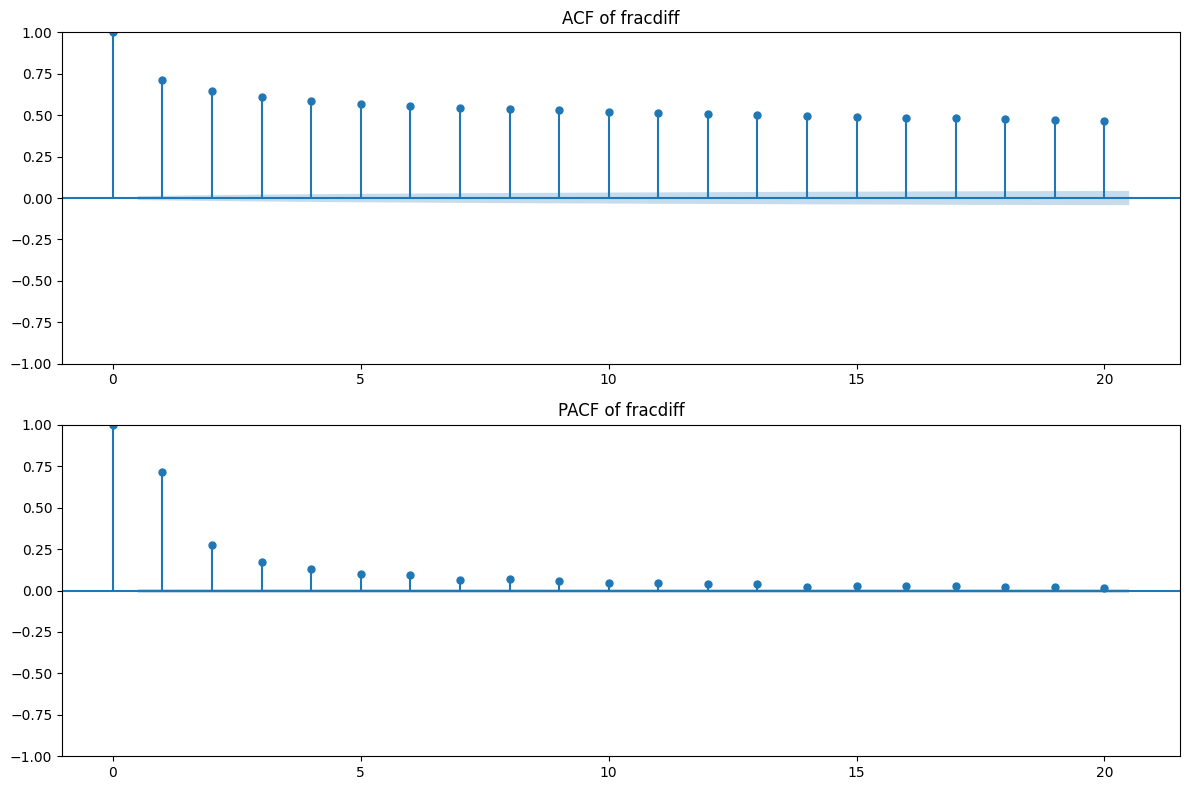

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df['fracdiff'], ax=axes[0], lags=20, title="ACF of fracdiff")
plot_pacf(df['fracdiff'], ax=axes[1], lags=20, title="PACF of fracdiff")
plt.tight_layout()
plt.show()


In [57]:
lags = [1, 2, 3, 6, 12, 24]

for lag in lags:
    df[f'fracdiff_lag{lag}'] = df['fracdiff'].shift(lag)

# Feature importance

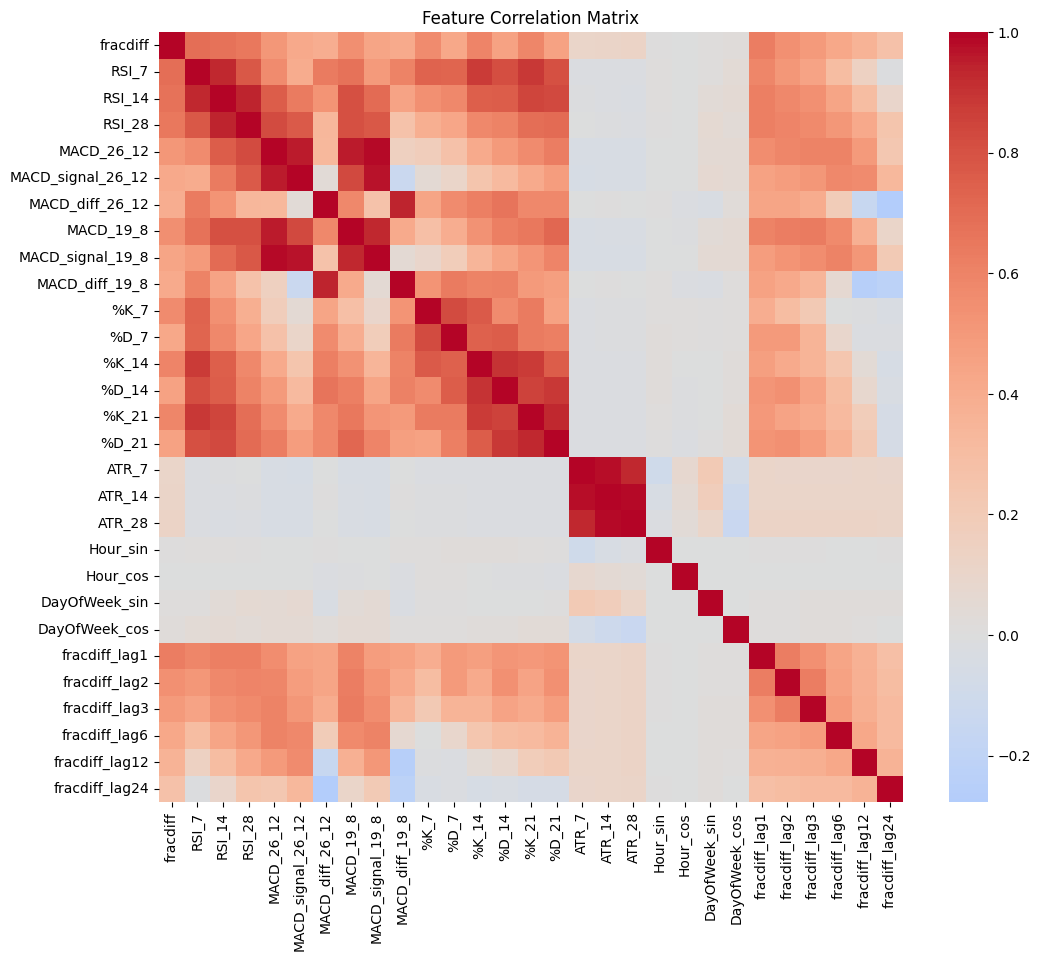

Highly correlated feature pairs (corr > 0.9):
('RSI_7', 'RSI_14', 0.9306505293681101)
('RSI_14', 'RSI_28', 0.9387079555553467)
('MACD_26_12', 'MACD_signal_26_12', 0.9563340055355978)
('MACD_26_12', 'MACD_19_8', 0.95932905650411)
('MACD_26_12', 'MACD_signal_19_8', 0.989156292067344)
('MACD_signal_26_12', 'MACD_signal_19_8', 0.9654749417289229)
('MACD_diff_26_12', 'MACD_diff_19_8', 0.9442663891395366)
('MACD_19_8', 'MACD_signal_19_8', 0.932440983833872)
('%K_21', '%D_21', 0.9327886426966427)
('ATR_7', 'ATR_14', 0.9796817167017008)
('ATR_7', 'ATR_28', 0.9311951985729775)
('ATR_14', 'ATR_28', 0.9814127664767609)


In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_cols = ['fracdiff', 'RSI_7', 'RSI_14',
       'RSI_28', 'MACD_26_12', 'MACD_signal_26_12', 'MACD_diff_26_12',
       'MACD_19_8', 'MACD_signal_19_8', 'MACD_diff_19_8', '%K_7', '%D_7',
       '%K_14', '%D_14', '%K_21', '%D_21', 'ATR_7', 'ATR_14', 'ATR_28',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
       'fracdiff_lag1', 'fracdiff_lag2', 'fracdiff_lag3', 'fracdiff_lag6',
       'fracdiff_lag12', 'fracdiff_lag24']

df_features = df[df["DateTime"] < '2023-11-01'].dropna().iloc[:-lookahead]  
df_features = df_features[feature_cols]

corr_matrix = df_features.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

threshold = 0.9
high_corr_pairs = []
cols = df_features.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((cols[i], cols[j], corr_matrix.iloc[i, j]))

print("Highly correlated feature pairs (corr > 0.9):")
for pair in high_corr_pairs:
    print(pair)


In [59]:
df = df.drop(["RSI_14", "RSI_28", 'MACD_signal_26_12',
    'MACD_19_8',
    'MACD_signal_19_8',
    'MACD_diff_19_8', "%D_21", "ATR_7", "ATR_28"], axis=1, errors='ignore')

# Purged and embargoed RFECV

Target: ReturnBin10


Optimal number of features: 9
Feature ranking: [ 1  5  1  1 11  4  9  1  2  1  1  1  1  1 12  7  8 10  3  6]
Selected features: ['fracdiff', 'MACD_26_12', 'MACD_diff_26_12', '%D_14', 'ATR_14', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']


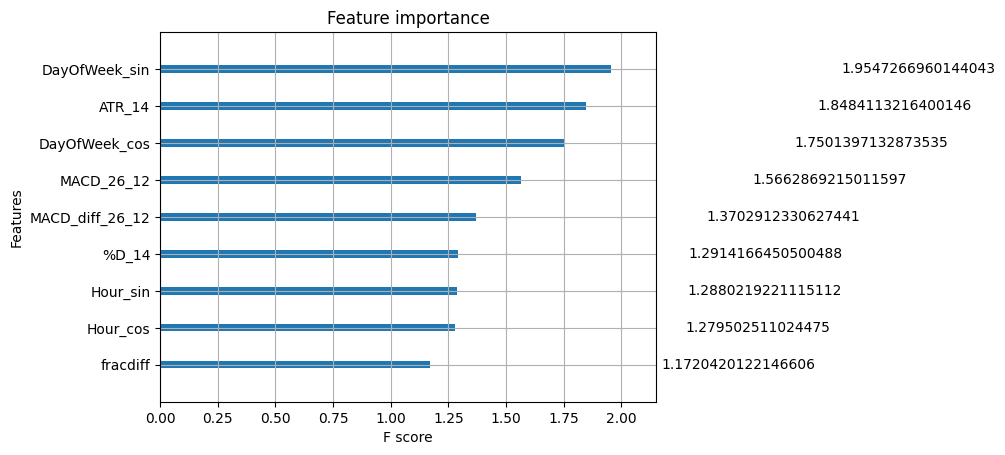

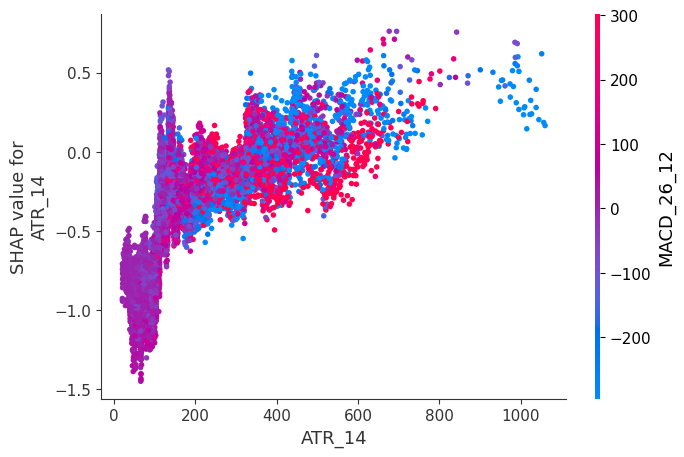

Target: ReturnBinQuantile
Optimal number of features: 9
Feature ranking: [ 1  2  1  1 11  5  9  3  1  1  1  1  1  1  8 12  6 10  7  4]
Selected features: ['fracdiff', 'MACD_26_12', 'MACD_diff_26_12', '%K_21', 'ATR_14', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']


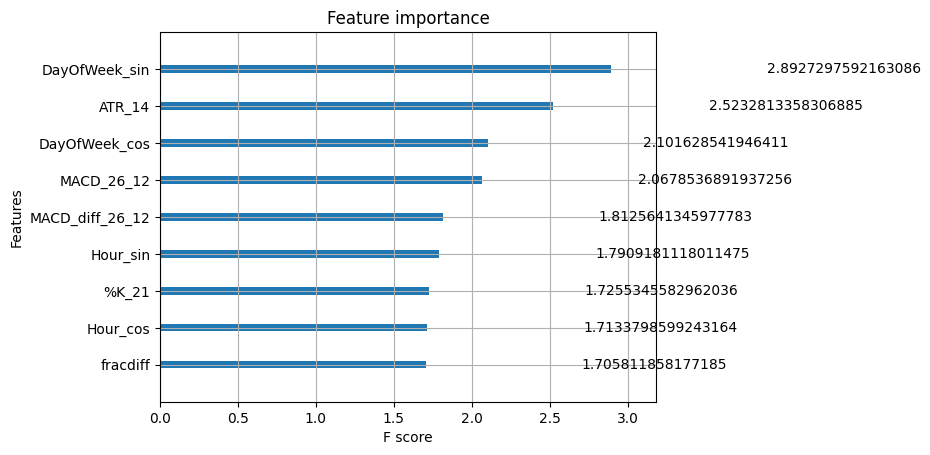

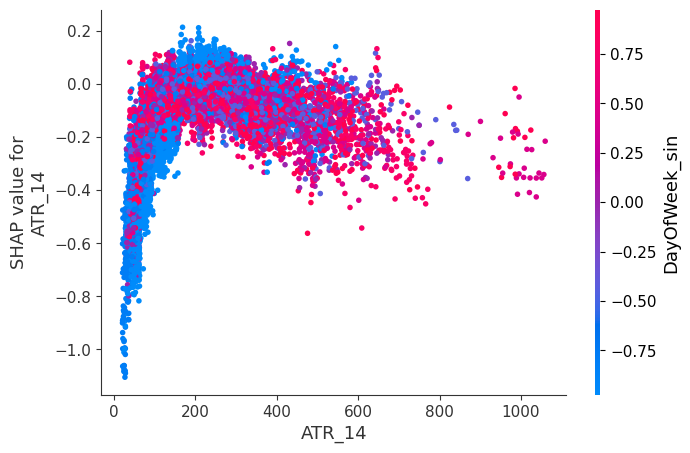

Target: ReturnBin10_manual_bell
Optimal number of features: 12
Feature ranking: [1 1 1 1 6 3 2 1 1 1 1 1 1 1 8 1 9 7 4 5]
Selected features: ['fracdiff', 'RSI_7', 'MACD_26_12', 'MACD_diff_26_12', '%D_14', '%K_21', 'ATR_14', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'fracdiff_lag2']


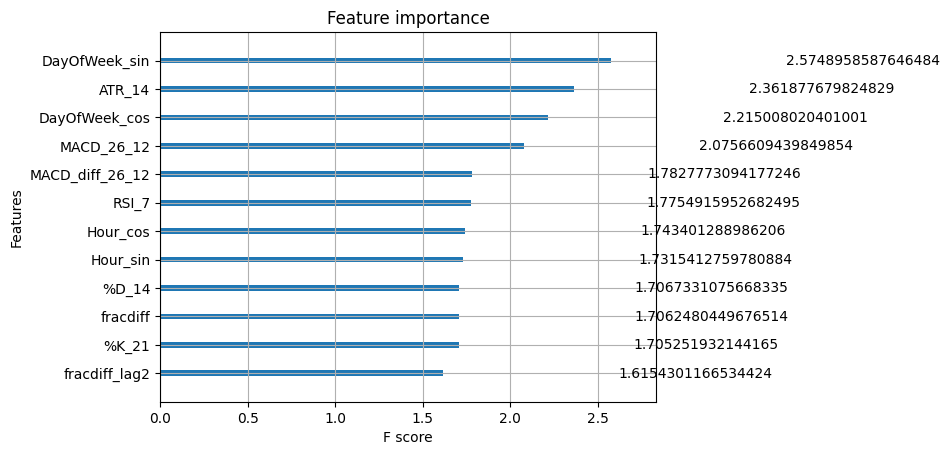

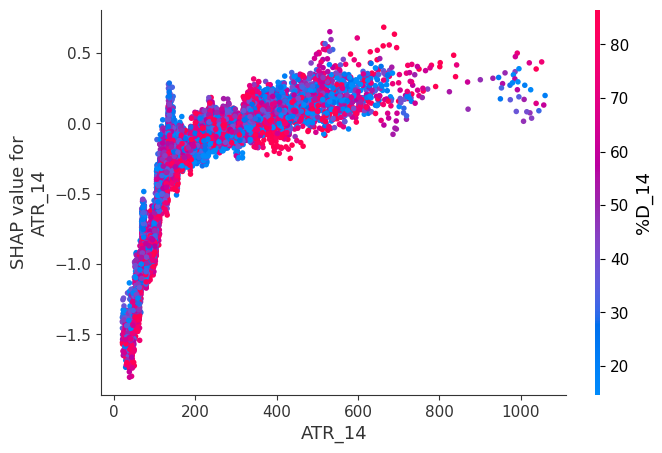

In [60]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from typing import Optional
from sklearn.model_selection import BaseCrossValidator


class PurgedKFold(BaseCrossValidator):
    def __init__(self, n_splits=3, t1: Optional[np.ndarray] = None, pctEmbargo: float = 0.0):
        """
        Parameters
        ----------
        n_splits : int
            Number of folds.
        t1 : np.ndarray
            A Series of shape (n_samples,) where each entry t1[i]
            is the 'last time' that the label at row i depends on.
            In your case, it's integer-based: t1[i] = index[i] + lookahead.
        pctEmbargo : float
            Percentage (0.0 to 1.0) of the dataset to 'embargo' on the right side.
        """
        super().__init__()

        self.n_splits = n_splits
        self.t1 = t1
        self.pctEmbargo = pctEmbargo

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        if X.shape[0] != len(self.t1):
            raise ValueError("X and t1 must have the same number of rows")

        indices = np.arange(X.shape[0])
        n_samples = X.shape[0]
        mbrg = int(n_samples * self.pctEmbargo)

        # Split indices into n_splits contiguous folds
        test_starts = [(fold[0], fold[-1] + 1)
                    for fold in np.array_split(indices, self.n_splits)]

        for i, j in test_starts:
            test_indices = indices[i:j]

            # t0 is the "start time" index for the test fold
            t0 = i

            # The max label value in the test set
            maxTestLabelValue = self.t1[test_indices].max()

            # Find last location of that maxTestLabelValue in t1
            maxTestLabelIdx_array = np.where(self.t1 == maxTestLabelValue)[0]
            if len(maxTestLabelIdx_array) == 0:
                # In case we never find it (edge case)
                maxTestLabelIndex = j
            else:
                maxTestLabelIndex = maxTestLabelIdx_array[-1]

            # Left train set
            train_indices_left = np.where(self.t1 <= t0)[0]

            # Right train set (embargo)
            if maxTestLabelIndex < n_samples:
                train_indices_right = indices[maxTestLabelIndex + mbrg:]
                train_indices = np.concatenate((train_indices_left, train_indices_right))
            else:
                train_indices = train_indices_left

            yield train_indices, test_indices
# X, y = preprocessed feature matrix & target
# t1 = a ndarray with index matching X and values = "end time" for each observation
# e.g. t1[i] = last time (timestamp) that the label at i depends on

# X.shape -> (num_samples, num_features)
# X.index -> DatetimeIndex matching t1.index
# y.shape -> (num_samples,)
# t1.shape -> (num_samples,)


n_splits = 5
pct_embargo = 0.01  # 1% of the data as embargo

df_dropped = df[df['DateTime'] < '2023-11-01'].dropna().iloc[:-lookahead]
X = df_dropped[[fc for fc in feature_cols if fc in df]]
t1 = (df_dropped.index.to_series() + lookahead).to_numpy()
purged_cv = PurgedKFold(n_splits=n_splits, t1=t1, pctEmbargo=pct_embargo)

xgb_estimator = XGBClassifier(
    random_state=42,
    num_class=5,
    objective='multi:softprob',
    #objective='multi:softmax'
)

rfecv = RFECV(
    estimator=xgb_estimator,
    step=1,
    cv=purged_cv,
    #scoring='accuracy',
    scoring='f1_macro',
    n_jobs=-1
)

# for each target
targets = ["ReturnBin10","ReturnBinQuantile","ReturnBin10_manual_bell"]
for target in targets:
    print("Target:", target)
    y = df_dropped[target]
    rfecv.fit(X, y)

    selected_columns = list(X.columns[rfecv.support_])
    print("Optimal number of features:", rfecv.n_features_)
    print("Feature ranking:", rfecv.ranking_)
    print("Selected features:", selected_columns)

    left_outs = list(set(feature_cols) - set(selected_columns))
    dftosave = df.drop(left_outs, axis=1, errors='ignore').dropna().copy()
    dftosave = dftosave.drop(targets, axis=1)
    dftosave["Target"] = df[target]
    dftosave.to_csv(os.path.join("eDo", 'data', f'04-{target}.csv'), index=False) 

    # retrain

    selected_features = X.columns[rfecv.support_]
    X_selected = X[selected_features]
    final_model = XGBClassifier(
        random_state=42,
        num_class=len(np.unique(y)),
        objective='multi:softprob'
    )
    final_model.fit(X_selected, y)

    from xgboost import plot_importance
    plot_importance(final_model, importance_type='gain')
    plt.show()

    import shap
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_selected)

    #shap.summary_plot(shap_values, X_selected, plot_type='bar')
    # for cl in range(shap_values.shape[2]):
    #     shap_values_class =shap_values[:, :, cl]

    #     shap.dependence_plot(
    #         'ATR_14',
    #         shap_values_class,
    #         X_selected,
    #     )

    shap_values_mean = shap_values.mean(axis=2)

    shap.dependence_plot(
        'ATR_14',
        shap_values_mean,
        X_selected
    )
